# Compare different model outputs against empirical metrics of US MSA income distributions


Descriptive Characteristics of Empirical Distributions, against which to compare models:
- general shape
- decile scaling
- moments vs. population (especially 3rd)
    - NOTE: What about 1st moment? effectively, what about actual scaling behavior across size that won't show up?



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import sklearn.metrics as sk
import scipy.stats
from scipy.optimize import curve_fit
#from RegscorePy import *
from IPython.core.debugger import set_trace
import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import lmfit 
#import import_ipynb
#import KEM_Rand

# Input from Data & Model Output
DATA:
Should be saved as pdfs of cities, formatted as 

MODEL OUTPUT:
Should be saved as numpy binary file, formatted as "<model-name>.npy"
The numpy object should be an array with each row representing a city output as a two-element list, with the first element being the population size and the second being an array of the income distribution of that model city.
    Example: 
        "KEM_randnet.npy" = array([[3, array([1, 2])],
                               [5, array([2, 3])]], dtype=object)
        , in which 3 and 5 are population sizes, and the arrays [1,2] and [2,3] are the respective income distributions of
          those cities 

## Input from Model

In [2]:
# CHANGE FILENAMES AND NAMES HERE FOR APPROPRIATE MODEL OUTPUTs
modelA_data = np.load("IPDOSmallWorldNetwork;k=50,p=0.01_02-27.npy",allow_pickle=True)
modelA_name = "IPDO on Small-World Network"
modelB_data = np.load("IPDORandomNetwork_02-27.npy",allow_pickle=True)
modelB_name = "IPDO on Random Network"

In [3]:
m_incomes = {}
m_pops = {}
m_pops["A"] =    modelA_data[:,0]
m_incomes["A"] = modelA_data[:,1]
m_pops["B"] =    modelB_data[:,0]
m_incomes["B"] = modelB_data[:,1]

## Input from Data

In [5]:
data = pd.read_csv("empiricalAnalysis/CTScalingFiles/ct.distr.csv")
idmappings = pd.read_excel("empiricalAnalysis/CTScalingFiles/cbsaidmappings.xls").set_index("CBSA Code")


# maps MSA id to census tract incomes
income_lists = {}
# maps MSA id to census tract population
pops = {}
fullpops = {}
cts = set()
# populations of whole cities (DONE: Cross-check with other data)
city_pops = {}

# If True, will only read in data from MSAs (not Micropolitan SAs). If False, includes all data
ONLY_MSA = True

for _,ct in data.iterrows():
    msa = ct['msa']
    ct_id = ct["ct"]
    
    msa = str(msa)
    metro_micro_lbl = idmappings["Metropolitan/Micropolitan Statistical Area"][msa]
    if not isinstance(metro_micro_lbl,str):
        metro_micro_lbl = list(metro_micro_lbl)[0]
    metro = "Metro" in metro_micro_lbl
    
    # skip over entry if it's a Micro area and you've set the script to only read Metro (not Micro)
    if ONLY_MSA and not metro:
        continue
    
    #NOTE on data: "meandollars is total ct income / # workers... "
    ct_inc = ct["ct.meandollars"]
    pop = ct["ct.totalworkers"]
    fullpop = ct["ct.population"]
    if (ct["ct"],msa) in cts:
        print("WARNING! Found Double census tract id: "+str(ct["ct"]))
        set_trace()
    cts.add((ct["ct"],msa))
    
    if msa not in city_pops:
        city_pops[msa] = ct["pop.sum"]
    
    if msa not in income_lists or msa not in pops:
        income_lists[msa] = []
        pops[msa] = []
        fullpops[msa] = []
    income_lists[msa].append(ct_inc)
    pops[msa].append(pop)
    fullpops[msa].append(fullpop)

In [6]:
e_pops = list(city_pops.values())
e_ctpops = list(fullpops.values())
e_incomes = list(income_lists.values())

## create population list generated from empirical city sizes scaled down to managable sizes

In [9]:
outpop_raw = np.array(sorted(e_pops))
max_model_pop = 20000.
factor = (max_model_pop/np.max(outpop_raw))
print("scaling down by: ",1./factor)
outpop = outpop_raw * factor
# print(outpop)
outpop = list(map(lambda x: round(x,-2), list(outpop)))
outpop = np.unique(np.array(outpop))
print(outpop)
np.save("empirical-model_pops.npy",outpop)

scaling down by:  1015.8311
[  100.   200.   300.   400.   500.   600.   700.   800.   900.  1000.
  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.  2000.
  2100.  2200.  2300.  2400.  2500.  2800.  2900.  3000.  3300.  3600.
  4400.  4500.  4600.  5000.  5800.  6200.  6300.  6400.  6900.  9600.
 13100. 20000.]


# General Shape

## Model

In [ ]:

"""
creates and displays a probability distribution function of the model 
incomes, generated from a Gaussian Kernel Density Estimation
"""

def wide_silverman(kde_inst):
    n = kde_inst.n
    d = kde_inst.d
    silverman = (n * (d + 2) / 4.)**(-1. / (d + 4))
    scale = 2.
    return silverman*scale

incomes = np.array(sim.get_income_dist())
# print(min(incomes))
# incomes *= 300000./np.max(incomes)
kde = scipy.stats.gaussian_kde(sim.get_income_dist(),bw_method=wide_silverman)
x = np.linspace(0,1.2*max(incomes),100)




#ax1 = sns.kdeplot(income_list, bw=1)

datx,daty = x,kde.pdf(x)

plt.figure()
plt.plot(datx,daty,c='red')
ax2 = sns.rugplot(incomes)

plt.title("Pure Random KEM Simulation")
plt.xlabel("income")
plt.ylabel("probability")
plt.show()
plt.close()





## Empirical

In [ ]:
kde_distr = {}
kde_distr_small = {}
kde_pdfs = {}
x_inc_all = []
y_pop_all = []


def wide_silverman(kde_inst):
    n = kde_inst.n
    d = kde_inst.d
    silverman = (n * (d + 2) / 4.)**(-1. / (d + 4))
    scale = 2.
    return silverman*scale



for msa in income_lists:
    income_list = income_lists[msa]
    #set_trace()
    #print(income_list)
    pop = fullpops[msa]
    x = np.linspace(0,1.2*max(income_list),100)
    income_list = np.array(income_list)
    pop = np.array(fullpops[msa])/sum(fullpops[msa])
    
    plt.figure()
    
    kernel = scipy.stats.gaussian_kde(income_list,weights=pop,bw_method=wide_silverman)
    
    
    
    sumprob = scipy.integrate.quad(kernel.pdf,0,1.2*max(income_list))
    
    
    
    
    #ax1 = sns.kdeplot(income_list, bw=1)
    
    datx,daty = x,kernel.pdf(x)
    
    plt.plot(datx,daty,c='red')
    ax2 = sns.rugplot(income_list)
    
    metro = str(msa) in metro_ids
    msaname = idmappings["CBSA Title"][str(msa)]
    if not isinstance(msaname,str):
        msaname = list(msaname)[0]
    if metro:
        msaname += " (Metro Area)"
    else:
        msaname += " (Micro Area)"
        
    plt.title(msaname)
    plt.xlabel("income")
    plt.ylabel("probability")
    
    
#     plt.plot(support,kernel,c='orange')
# #     kde_distr[msa] = (support, kernel)
    n_samples = round(n_cts[msa]**.75/6)
    if n_samples < 15:
        n_samples = 15
    small_sample = np.linspace(0,1.2*max(income_list),n_samples)
    kde_distr[msa] = (datx, daty)
    kde_distr_small[msa] = (small_sample, kernel.pdf(small_sample))
    kde_pdfs[msa] = kernel.pdf
    
    
    
    
    plt.show()
    plt.close()

# Moment distribution

## Model

MODEL: A
completed pop 100.0
completed pop 200.0
completed pop 300.0
completed pop 400.0
completed pop 500.0
completed pop 600.0
completed pop 700.0
completed pop 800.0
completed pop 900.0
completed pop 1000.0
completed pop 1100.0
completed pop 1200.0
completed pop 1300.0
completed pop 1400.0
completed pop 1500.0
completed pop 1600.0
completed pop 1700.0
completed pop 1800.0
completed pop 1900.0
completed pop 2000.0
completed pop 2100.0
completed pop 2200.0
completed pop 2300.0
completed pop 2400.0
completed pop 2500.0
completed pop 2800.0
completed pop 2900.0
completed pop 3000.0
completed pop 3300.0
completed pop 3600.0
completed pop 4400.0
completed pop 4500.0
completed pop 4600.0
completed pop 5000.0
completed pop 5800.0
completed pop 6200.0
completed pop 6300.0
completed pop 6400.0
completed pop 6900.0
completed pop 9600.0
completed pop 13100.0
completed pop 20000.0


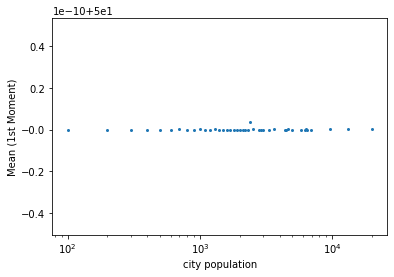

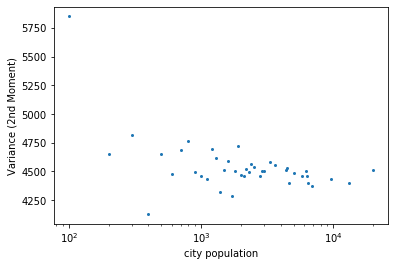

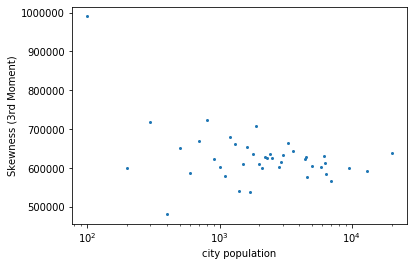

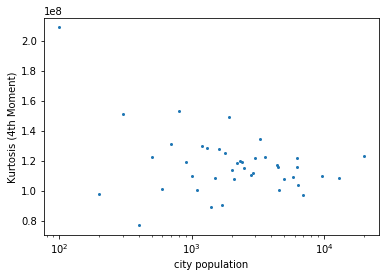

MODEL: B
completed pop 100.0
completed pop 200.0
completed pop 300.0
completed pop 400.0
completed pop 500.0
completed pop 600.0
completed pop 700.0
completed pop 800.0
completed pop 900.0
completed pop 1000.0
completed pop 1100.0
completed pop 1200.0
completed pop 1300.0
completed pop 1400.0
completed pop 1500.0
completed pop 1600.0
completed pop 1700.0
completed pop 1800.0
completed pop 1900.0
completed pop 2000.0
completed pop 2100.0
completed pop 2200.0
completed pop 2300.0
completed pop 2400.0
completed pop 2500.0
completed pop 2800.0
completed pop 2900.0
completed pop 3000.0
completed pop 3300.0
completed pop 3600.0
completed pop 4400.0
completed pop 4500.0
completed pop 4600.0
completed pop 5000.0
completed pop 5800.0
completed pop 6200.0
completed pop 6300.0
completed pop 6400.0
completed pop 6900.0
completed pop 9600.0
completed pop 13100.0
completed pop 20000.0


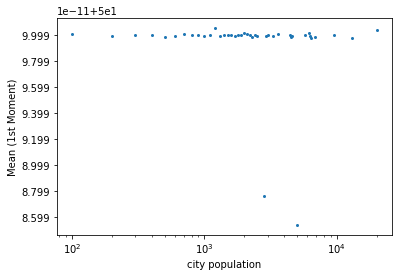

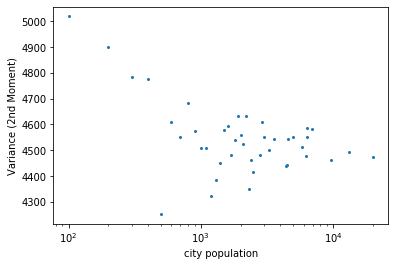

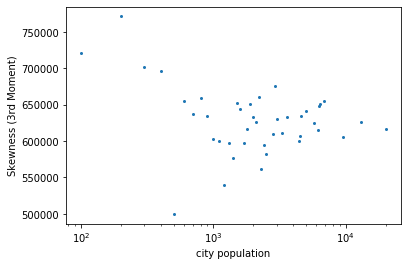

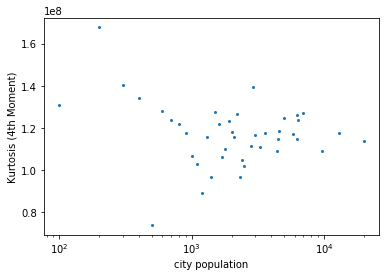

In [6]:
import scipy.stats
import seaborn as sns

m_kdes = {}
for model in ["A","B"]:
    m_kdes[model] = {}

# create kde pdfs
for model in ["A","B"]:
    for pop,income in zip(m_pops[model],m_incomes[model]):
        m_kdes[model][pop] = scipy.stats.gaussian_kde(income)#,bw_method=wide_silverman)


class custom_distribution(scipy.stats.rv_continuous):
    def _pdf(self, x, msa):
        #print("in pdf",x)
#         if first:
#             print("in pdf,x = ",x,"msa=",msa,"model = ", model)
        ret = m_kdes[model][msa[0]](x[0])
        #print(ret)
        #print("ret=",ret)
        return ret

distribution = custom_distribution(momtype=0)


# maps moment number n to list of those moments
moments = {}
cpops = {}

for model in ["A","B"]:
    print("MODEL:",model)
    moments[model] = {}
    cpops[model] = []
    first = True
    for psize in m_pops[model]: 
        for n in range(1,5):
            if n not in moments[model]:
                moments[model][n] = []
#             set_trace()
            # FIXME: not running for every city in model, only returning one value
#             print(moments)
            moments[model][n].append(distribution.moment(n,psize))
            first = False
#             print("moment: n, val,pop:",n,moments[model][n],psize)
        print("completed pop",psize)
        cpops[model].append(psize)
    
    scale_y = {
          1:1.,
          2:1.,
          3:1.,
          4:1.,
          5:1.
#         1:1.,
#         2:.5,
#         3:.3,
#         4:.3,
#         5:.15
    }

    #TODO: What's going on with the moments that evaluate to zero???

    for n in range(1,5):
        plt.figure()
        plt.xlabel("city population")
        lbl = "nth moment, n = " + str(n) 
        if n == 2:
            lbl = "Variance (2nd Moment)"
        elif n == 1:
            lbl = "Mean (1st Moment)"
        elif n == 3:
            lbl = "Skewness (3rd Moment)"
        elif n == 4:
            lbl = "Kurtosis (4th Moment)"
        plt.ylabel(lbl)
        # TODO: fit regressions in log-linear space, calculate R^2 & p-value
        plt.plot(cpops[model],moments[model][n],'o',markersize=2)
        bottom,top = plt.ylim()
        plt.ylim((bottom,scale_y[n]*top))
        #plt.yscale("log")
        plt.xscale("log")
        plt.show()
        plt.close()


## Empirical

### First, calculate kde pdfs

In [5]:
kde_pdfs = {}

def wide_silverman(kde_inst):
    n = kde_inst.n
    d = kde_inst.d
    silverman = (n * (d + 2) / 4.)**(-1. / (d + 4))
    scale = 2.
    return silverman*scale



for income_list,pop,cpop in zip(e_incomes,e_ctpops,e_pops):
    income_list = np.array(income_list)
    pop = np.array(pop)/sum(pop)    
    kernel = scipy.stats.gaussian_kde(income_list,weights=pop)#,bw_method=wide_silverman)
    kde_pdfs[cpop] = kernel.pdf


NameError: name 'e_incomes' is not defined

## calculate moments using pdfs generated by kde for each city
Uses scipy.stats.rv_continuous.moment
NOTE: Moments change significantly from raw data to kde-generated pdf. We assume that these changes are representative of the true distributions


    FIXME: Some moments are being returned as zero

In [18]:
# TODO: Stop using KDE pdfs?
class custom_distribution(scipy.stats.rv_continuous):
    def _pdf(self, x, msa):
        #print("in pdf,x = ",x,"msa=",msa)
        #print("in pdf",x)
        ret = kde_pdfs[msa[0]](x[0])
        #print(ret)
        #print("ret=",ret)
        return ret

distribution = custom_distribution(momtype=0)

# maps moment number n to list of those moments
moments = {}
cpops = []

for pop in kde_pdfs: 
#     for i in range(100):
#         print(i)
#         sample = distribution.rvs(msa)
#         samples.append(sample)
        
#     break

    #print("sample:",sample)
    for n in range(1,6):
        if n not in moments:
            moments[n] = []
        moments[n].append(distribution.moment(n,pop))
    cpops.append(pop)
        
#     other_std = np.std(income_lists[msa])
#     #print(std,other_std)
#     stds.append(std)
#     raw_stds.append(other_std)
#     #means.append(distribution.moment(1,msa))


/home/jake/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1688: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  args=(m,)+args)[0]


### Analyze distribution moments vs. city size

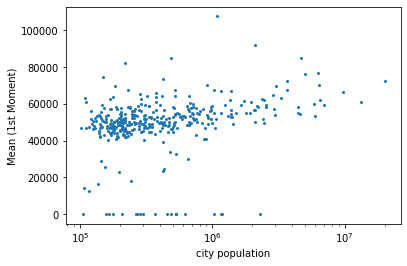

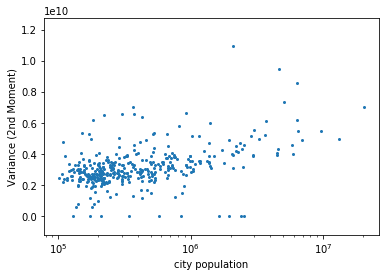

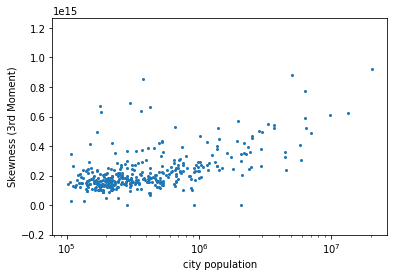

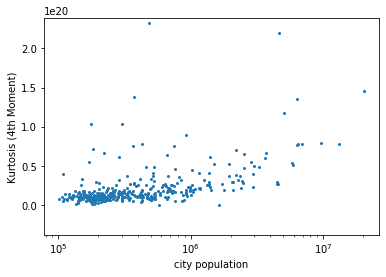

In [19]:
# moment_p = moments
# cpops_p = cpops

scale_y = {
    1:1.,
    2:.5,
    3:.3,
    4:.3,
    5:.15
}

#TODO: What's going on with the moments that evaluate to zero???

for n in range(1,5):
    plt.figure()
    plt.xlabel("city population")
    lbl = "nth moment, n = " + str(n) 
    if n == 2:
        lbl = "Variance (2nd Moment)"
    elif n == 1:
        lbl = "Mean (1st Moment)"
    elif n == 3:
        lbl = "Skewness (3rd Moment)"
    elif n == 4:
        lbl = "Kurtosis (4th Moment)"
    plt.ylabel(lbl)
    # TODO: fit regressions in log-linear space, calculate R^2 & p-value
    plt.plot(cpops,moments[n],'o',markersize=2)
    bottom,top = plt.ylim()
    plt.ylim((bottom,scale_y[n]*top))
    #plt.yscale("log")
    plt.xscale("log")
    plt.show()
    plt.close()
#plt.hist(samples)


# Decile Scaling

## Empirical

[ 8.25097804 -0.01176748]
[ 8.27880077e+00 -9.97510468e-04]
[8.19407966 0.01221861]
[8.12291218 0.0230467 ]
[8.0292634  0.03503435]
[7.93495772 0.04706884]
[7.79697342 0.06278315]
[7.67005023 0.07888204]
[7.49029027 0.10159293]
[6.96151438 0.16120646]


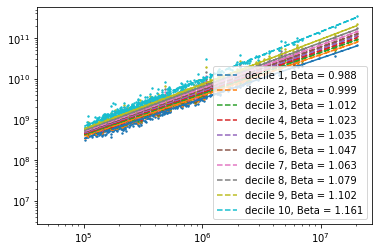

In [33]:
# maps int (1-10) to pair (list of income_pp,list of city size)
deciles = {}
for i in range(1,11):
    deciles[i] = ([],[])

# empirical case:
for e_income,e_pop,e_ctpop in zip(e_incomes,e_pops,e_ctpops):

        #split into deciles
        sum_pop = sum(e_ctpop)
        pop_cutoffs = [sum_pop*float(i)/10. for i in range(1,11)]
        cumulative_pop = 0.
        current_decile = 1
        # summed population and income for current decile
        decile_pop = 0.
        decile_inc = 0.
        # sort by income
        e_income,e_ctpop = (list(t) for t in zip(*sorted(zip(e_income, e_ctpop))))
        for ctpop, ctinc in zip(e_ctpop,e_income):
            cumulative_pop += ctpop
            decile_pop += ctpop
            decile_inc += ctinc*ctpop
            if cumulative_pop >= pop_cutoffs[(current_decile - 1)]:
    #             if cumulative_pop == pop_cutoffs[9]:
    #                 print("finish reached")
                current_decile += 1
                #store in deciles
                correction = (sum_pop/10.)/(decile_pop)
                decile_inc *= correction 
                #print(correction)
                #print("Decile:",decile_pop,"full/10:",(sum_pop/10.),"with correction",decile_pop*correction)
                
                deciles[(current_decile-1)][0].append(decile_inc)
                deciles[(current_decile-1)][1].append(e_pop)
                #reset
                decile_pop = 0
                decile_inc = 0

#         sum_inc = np.sum(np.array(income_list)*np.array(pop))

        
def standardModelFunc(x,y0,delta):
    return y0*(x**(1+delta))
def standardLogResidual(params, x, true_data):
    model = standardModelFunc(x,params['y0'],params['delta'])
    return np.log(true_data)-np.log(model)
        
def standardLogMod(x,logy0,delta):
    return logy0+x*(1+delta)
    
plt.figure()
ax = plt.gca()
decileFits = {}
decileModels = {}
decileParams = {}
for i in range(1,11):
    x= list(deciles[i][1])
    y = list(deciles[i][0])
    #print("decile:",i,"x,y = ",x,y)
    plt.scatter(x,y,s=2)
    decileParams[i] = lmfit.Parameters()
    decileParams[i].add_many(('y0',8*list(y)[0]/list(x)[0],True,0,1),('delta',0.,True))
    

    decileModels[i] = lmfit.Model(standardModelFunc)
    decileFits[i] = lmfit.minimize(standardLogResidual, decileParams[i], args=(x, y))
    decileParams[i] = decileFits[i].params
    
    #using curve_fit
    logx = np.log(x)
    logy = np.log(y)
    coeff, var = curve_fit(standardLogMod, logx, logy)
    
    lbl = "decile "+str(i)+", Beta = "+str(round((1.+coeff[1]),3))
#     print(coeff)
    fity = np.exp(np.array(coeff[0],dtype=np.float128))*x**(1+coeff[1])
    #print(x,fity)
    ax.plot(x, fity,'--',label=lbl,markersize=1)
    #ax.plot(x,decileModels[i].eval(decileParams[i],x=x),'--',label=lbl)
    

ax.set_yscale("log")
ax.set_xscale("log")
plt.legend()


## Model

TODO: Compare what exactly???

A
B


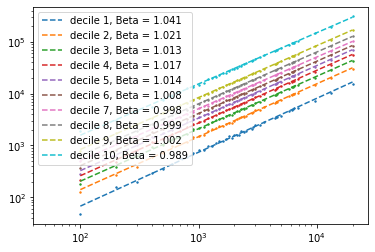

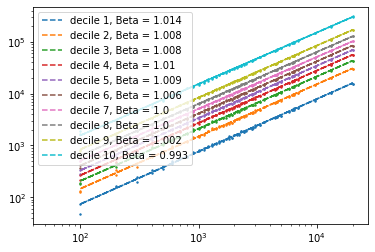

In [4]:
# maps int (1-10) to pair (list of income_pp,list of city size)
deciles = {}
for i in range(1,11):
    deciles[i] = ([],[])

for model in ["A","B"]:
    print(model)
    fake_ctpops = np.ones((len(m_incomes[model]),len(m_incomes[model][0])))
    for m_income,m_pop in zip(m_incomes[model],m_pops[model]):

            m_ctpop = np.ones((len(m_income)))
#             print(m_ctpop)
#             set_trace()
            #split into deciles
            sum_pop = sum(m_ctpop)
            pop_cutoffs = [sum_pop*float(i)/10. for i in range(1,11)]
            cumulative_pop = 0.
            current_decile = 1
            # summed population and income for current decile
            decile_pop = 0.
            decile_inc = 0.
            # sort by income
            m_income,m_ctpop = (list(t) for t in zip(*sorted(zip(m_income, m_ctpop))))
            for ctpop, ctinc in zip(m_ctpop,m_income):
                cumulative_pop += ctpop
                decile_pop += ctpop
                decile_inc += ctinc*ctpop
                if cumulative_pop >= pop_cutoffs[(current_decile - 1)]:
#                     set_trace()
        #             if cumulative_pop == pop_cutoffs[9]:
        #                 print("finish reached")
                    current_decile += 1
                    #store in deciles
                    correction = (sum_pop/10.)/(decile_pop)
                    decile_inc *= correction 
                    if abs(1.0-correction) > 0.0001:
                        print("correction is not equal to 1!")
#                     print("population:", m_pop, "decile:",current_decile,"sum income:",decile_inc)
                    #print(correction)
                    #print("Decile:",decile_pop,"full/10:",(sum_pop/10.),"with correction",decile_pop*correction)

                    deciles[(current_decile-1)][0].append(decile_inc)
                    deciles[(current_decile-1)][1].append(m_pop)
                    #reset
                    decile_pop = 0
                    decile_inc = 0

            sum_inc = np.sum(np.array(m_income)*np.array(m_ctpop))
#             print("sum_inc:",sum_inc)
#             print("pop:",m_pop)


    def standardModelFunc(x,y0,delta):
        return y0*(x**(1+delta))
    def standardLogResidual(params, x, true_data):
        model = standardModelFunc(x,params['y0'],params['delta'])
        return np.log(true_data)-np.log(model)

    def standardLogMod(x,logy0,delta):
        return logy0+x*(1+delta)

    plt.figure()
    ax = plt.gca()
    decileFits = {}
    decileModels = {}
    decileParams = {}
    for i in range(1,11):
        x= list(deciles[i][1])
        y = list(deciles[i][0])
        #print("decile:",i,"x,y = ",x,y)
        plt.scatter(x,y,s=2)
        decileParams[i] = lmfit.Parameters()
        decileParams[i].add_many(('y0',8*list(y)[0]/list(x)[0],True,0,1),('delta',0.,True))


        decileModels[i] = lmfit.Model(standardModelFunc)
        decileFits[i] = lmfit.minimize(standardLogResidual, decileParams[i], args=(x, y))
        decileParams[i] = decileFits[i].params

        #using curve_fit
        logx = np.log(x)
        logy = np.log(y)
        coeff, var = curve_fit(standardLogMod, logx, logy)

        lbl = "decile "+str(i)+", Beta = "+str(round((1.+coeff[1]),3))
    #     print(coeff)
        fity = np.exp(np.array(coeff[0],dtype=np.float128))*x**(1+coeff[1])
        #print(x,fity)
        ax.plot(x, fity,'--',label=lbl,markersize=1)
        #ax.plot(x,decileModels[i].eval(decileParams[i],x=x),'--',label=lbl)


    ax.set_yscale("log")
    ax.set_xscale("log")
    plt.legend()


[5143.751378666259, 24685.94262902863, 50733.77662110774, 98610.14195760473, 198736.29433335946, 502115.0883107309]


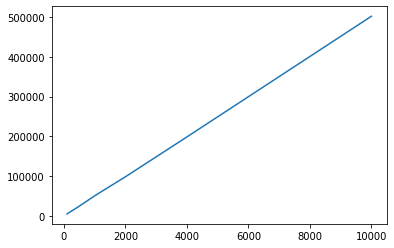

In [12]:
# m_incomes["A"] = np.array(m_incomes["A"])
# print(m_incomes["A"])
sum_incs = list(map(lambda x: np.sum(x),m_incomes["A"]))
print(sum_incs)
plt.plot(m_pops["A"],sum_incs)